In [1]:
# AdaBoost和随机森林应用于宫颈癌风险因素数据集
# 该数据集包含约32个具有临床意义的风险因素特征

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.impute import SimpleImputer
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

# 设置随机种子
np.random.seed(42)

In [2]:
# 1. 加载宫颈癌风险因素数据集
print("加载宫颈癌风险因素数据集...")

# 数据集来源: UCI Machine Learning Repository
# 该数据集包含以下临床有意义的特征，可用于预测宫颈癌风险和筛查结果
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00383/risk_factors_cervical_cancer.csv"
#请在这完成数据集加载
data = pd.read_csv(url)

加载宫颈癌风险因素数据集...


In [3]:
# 2. 数据探索
print("\n数据集基本信息:")
print(f"原始样本数量: {data.shape[0]}")
print(f"原始特征数量: {data.shape[1]}")

print("\n目标变量分布:")
target_columns = ['Hinselmann', 'Schiller', 'Citology', 'Biopsy']
for col in target_columns:
    positive_count = data[col].sum()
    print(f"{col}: 阳性 {positive_count} 样本 ({positive_count/len(data):.2%})")

# 我们将使用Biopsy(活检)作为主要目标变量，这是金标准
target_col = 'Biopsy'
print(f"\n选择 {target_col} 作为主要目标变量")

# 检查缺失值
print("\n缺失值概况:")
missing_percent = data.isnull().sum() / len(data) * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)
print(missing_percent.head(10))

# 检查特征中的'?'值（在某些特征中表示缺失）
print("\n检查'?'值:")
for col in data.columns:
    if data[col].dtype == object:
        q_count = (data[col] == '?').sum()
        if q_count > 0:
            print(f"{col}: {q_count} '?'值 ({q_count/len(data):.2%})")



数据集基本信息:
原始样本数量: 858
原始特征数量: 36

目标变量分布:
Hinselmann: 阳性 35 样本 (4.08%)
Schiller: 阳性 74 样本 (8.62%)
Citology: 阳性 44 样本 (5.13%)
Biopsy: 阳性 55 样本 (6.41%)

选择 Biopsy 作为主要目标变量

缺失值概况:
Series([], dtype: float64)

检查'?'值:
Number of sexual partners: 26 '?'值 (3.03%)
First sexual intercourse: 7 '?'值 (0.82%)
Num of pregnancies: 56 '?'值 (6.53%)
Smokes: 13 '?'值 (1.52%)
Smokes (years): 13 '?'值 (1.52%)
Smokes (packs/year): 13 '?'值 (1.52%)
Hormonal Contraceptives: 108 '?'值 (12.59%)
Hormonal Contraceptives (years): 108 '?'值 (12.59%)
IUD: 117 '?'值 (13.64%)
IUD (years): 117 '?'值 (13.64%)
STDs: 105 '?'值 (12.24%)
STDs (number): 105 '?'值 (12.24%)
STDs:condylomatosis: 105 '?'值 (12.24%)
STDs:cervical condylomatosis: 105 '?'值 (12.24%)
STDs:vaginal condylomatosis: 105 '?'值 (12.24%)
STDs:vulvo-perineal condylomatosis: 105 '?'值 (12.24%)
STDs:syphilis: 105 '?'值 (12.24%)
STDs:pelvic inflammatory disease: 105 '?'值 (12.24%)
STDs:genital herpes: 105 '?'值 (12.24%)
STDs:molluscum contagiosum: 105 '?'值 (12.24%)
STDs:AIDS:

In [4]:
# 3. 数据预处理
print("\n进行数据预处理...")

# 请实现替换'?'为NaN
data.replace('?', np.nan, inplace=True)

# 将所有列转换为数值类型
for col in data.columns:
    if data[col].dtype == object:
        data[col] = pd.to_numeric(data[col], errors='coerce')

# 显示主要特征组
demographic_features = ['Age', 'Number of sexual partners', 'First sexual intercourse',
                        'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)']

contraceptive_features = ['Hormonal Contraceptives', 'Hormonal Contraceptives (years)',
                          'IUD', 'IUD (years)']

std_features = ['STDs', 'STDs (number)', 'STDs:condylomatosis', 'STDs:cervical condylomatosis',
               'STDs:vaginal condylomatosis', 'STDs:vulvo-perineal condylomatosis',
               'STDs:syphilis', 'STDs:pelvic inflammatory disease', 'STDs:genital herpes',
               'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV', 'STDs:Hepatitis B',
               'STDs:HPV']

other_medical_features = ['STDs: Time since first diagnosis', 'STDs: Time since last diagnosis',
                         'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx',
                         'Dx:Hinselmann', 'Dx:Schiller', 'Dx:Citology']

# 移除非特征和目标变量之外的筛查方法结果
features = data.drop(target_columns, axis=1)
y = data[target_col]

# 处理缺失值 - 临床上合理的方法
print("\n处理缺失值...")

# 对于大多数特征使用中位数填充
imputer = SimpleImputer(strategy='median')
features_imputed = pd.DataFrame(imputer.fit_transform(features), columns=features.columns)

# 特殊处理: 将STD相关的NA视为0(无STD)
std_cols = [col for col in features.columns if 'STD' in col]
for col in std_cols:
    na_indices = features[col].isna()
    features_imputed.loc[na_indices, col] = 0

# 记录填充后的数据
X = features_imputed

print(f"\n预处理后的特征数量: {X.shape[1]}")
print(f"预处理后的样本数量: {X.shape[0]}")

# 列出所有模型将使用的特征
print("\n模型将使用的特征列表:")
for i, col in enumerate(X.columns):
    print(f"{i+1}. {col}")



进行数据预处理...

处理缺失值...

预处理后的特征数量: 32
预处理后的样本数量: 858

模型将使用的特征列表:
1. Age
2. Number of sexual partners
3. First sexual intercourse
4. Num of pregnancies
5. Smokes
6. Smokes (years)
7. Smokes (packs/year)
8. Hormonal Contraceptives
9. Hormonal Contraceptives (years)
10. IUD
11. IUD (years)
12. STDs
13. STDs (number)
14. STDs:condylomatosis
15. STDs:cervical condylomatosis
16. STDs:vaginal condylomatosis
17. STDs:vulvo-perineal condylomatosis
18. STDs:syphilis
19. STDs:pelvic inflammatory disease
20. STDs:genital herpes
21. STDs:molluscum contagiosum
22. STDs:AIDS
23. STDs:HIV
24. STDs:Hepatitis B
25. STDs:HPV
26. STDs: Number of diagnosis
27. STDs: Time since first diagnosis
28. STDs: Time since last diagnosis
29. Dx:Cancer
30. Dx:CIN
31. Dx:HPV
32. Dx


In [5]:
# 5. 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# 标准化特征（对AdaBoost不是必须的，但对比较有帮助）
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

print(f"\n训练集样本数: {X_train.shape[0]}")
print(f"测试集样本数: {X_test.shape[0]}")


训练集样本数: 643
测试集样本数: 215


In [7]:
# 6. AdaBoost模型训练
print("训练AdaBoost模型...")


# 创建AdaBoost分类器
# 使用DecisionTreeClassifier作为基学习器，限制深度以防过拟合
ada_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=50,
    learning_rate=1.0,
    random_state=42
)

# 训练基础AdaBoost模型
ada_model.fit(X_train_scaled, y_train)

# 初始评估
ada_train_preds = ada_model.predict(X_train_scaled)
ada_test_preds = ada_model.predict(X_test_scaled)

print(f"初始AdaBoost模型训练集准确率: {accuracy_score(y_train, ada_train_preds):.4f}")
print(f"初始AdaBoost模型测试集准确率: {accuracy_score(y_test, ada_test_preds):.4f}")

训练AdaBoost模型...
初始AdaBoost模型训练集准确率: 0.9362
初始AdaBoost模型测试集准确率: 0.9349


In [11]:
# AdaBoost超参数调优
print("\n进行AdaBoost超参数调优...")
ada_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.5, 1.0, 1.5],
    'estimator__max_depth': [1, 2, 3]  # 决策桩的最大深度
}

ada_grid_search = GridSearchCV(
    estimator=AdaBoostClassifier(
        estimator=DecisionTreeClassifier(),
        random_state=42
    ),
    param_grid=ada_param_grid,
    scoring='roc_auc',  # 对不平衡数据集使用AUC更合适
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    verbose=1,
    n_jobs=-1
)

ada_grid_result = ada_grid_search.fit(X_train_scaled, y_train)

print("\nAdaBoost最佳超参数:")
print(ada_grid_result.best_params_)
print(f"AdaBoost最佳交叉验证ROC-AUC: {ada_grid_result.best_score_:.4f}")
# 使用最佳参数的AdaBoost模型
best_ada_model = ada_grid_result.best_estimator_



进行AdaBoost超参数调优...
Fitting 5 folds for each of 27 candidates, totalling 135 fits

AdaBoost最佳超参数:
{'estimator__max_depth': 1, 'learning_rate': 1.0, 'n_estimators': 200}
AdaBoost最佳交叉验证ROC-AUC: 0.5606


In [12]:
# 7. 随机森林模型训练
print("训练随机森林模型...")

# 创建随机森林分类器
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight='balanced'
)

# 训练基础随机森林模型
rf_model.fit(X_train_scaled, y_train)

# 初始评估
rf_train_preds = rf_model.predict(X_train_scaled)
rf_test_preds = rf_model.predict(X_test_scaled)

print(f"初始随机森林模型训练集准确率: {accuracy_score(y_train, rf_train_preds):.4f}")
print(f"初始随机森林模型测试集准确率: {accuracy_score(y_test, rf_test_preds):.4f}")

训练随机森林模型...
初始随机森林模型训练集准确率: 0.9813
初始随机森林模型测试集准确率: 0.9395


In [13]:
# 随机森林超参数调优
print("\n进行随机森林超参数调优...")
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid_search = GridSearchCV(
    estimator=RandomForestClassifier(
        random_state=42,
        class_weight='balanced'
    ),
    param_grid=rf_param_grid,
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    verbose=1,
    n_jobs=-1
)

rf_grid_result = rf_grid_search.fit(X_train_scaled, y_train)

print("\n随机森林最佳超参数:")
print(rf_grid_result.best_params_)
print(f"随机森林最佳交叉验证ROC-AUC: {rf_grid_result.best_score_:.4f}")

# 使用最佳参数的随机森林模型
best_rf_model = rf_grid_result.best_estimator_


进行随机森林超参数调优...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

随机森林最佳超参数:
{'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
随机森林最佳交叉验证ROC-AUC: 0.6044


In [14]:
# 8. 模型对比评估
print("模型对比评估")

models = {
    'AdaBoost': best_ada_model,
    'Random Forest': best_rf_model
}

results = {}

for name, model in models.items():
    print(f"\n{name} 模型评估:")
    print("-" * 40)
    
    # 预测
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # 计算各项指标
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    # ROC-AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    print(f"准确率: {accuracy:.4f}")
    print(f"精确率: {precision:.4f}")
    print(f"召回率: {recall:.4f}")
    print(f"F1分数: {f1:.4f}")
    print(f"AUC: {roc_auc:.4f}")
    
    # 存储结果
    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    # 混淆矩阵
    cm = confusion_matrix(y_test, y_pred)
    print(f"\n混淆矩阵:")
    print(cm)
    
    print(f"\n分类报告:")
    print(classification_report(y_test, y_pred))

模型对比评估

AdaBoost 模型评估:
----------------------------------------
准确率: 0.9349
精确率: 0.0000
召回率: 0.0000
F1分数: 0.0000
AUC: 0.6295

混淆矩阵:
[[201   0]
 [ 14   0]]

分类报告:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97       201
           1       0.00      0.00      0.00        14

    accuracy                           0.93       215
   macro avg       0.47      0.50      0.48       215
weighted avg       0.87      0.93      0.90       215


Random Forest 模型评估:
----------------------------------------
准确率: 0.9349
精确率: 0.5000
召回率: 0.1429
F1分数: 0.2222
AUC: 0.7072

混淆矩阵:
[[199   2]
 [ 12   2]]

分类报告:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       201
           1       0.50      0.14      0.22        14

    accuracy                           0.93       215
   macro avg       0.72      0.57      0.59       215
weighted avg       0.91      0.93      0.92       215



In [15]:
# 9. 特征重要性分析
print("特征重要性分析")

# AdaBoost特征重要性
print("\nAdaBoost前10个最重要特征:")
ada_feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_ada_model.feature_importances_
}).sort_values('importance', ascending=False)

print(ada_feature_importance.head(10))

# 随机森林特征重要性
print("\n随机森林前10个最重要特征:")
rf_feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(rf_feature_importance.head(10))

特征重要性分析

AdaBoost前10个最重要特征:
                             feature  importance
31                                Dx    0.182228
0                                Age    0.165979
3                 Num of pregnancies    0.119223
1          Number of sexual partners    0.102737
2           First sexual intercourse    0.094038
8    Hormonal Contraceptives (years)    0.091429
17                     STDs:syphilis    0.083981
6                Smokes (packs/year)    0.052863
26  STDs: Time since first diagnosis    0.046223
27   STDs: Time since last diagnosis    0.016186

随机森林前10个最重要特征:
                            feature  importance
0                               Age    0.160756
2          First sexual intercourse    0.144707
8   Hormonal Contraceptives (years)    0.143200
1         Number of sexual partners    0.107120
3                Num of pregnancies    0.106459
31                               Dx    0.038358
10                      IUD (years)    0.033926
6               Smokes (packs/yea

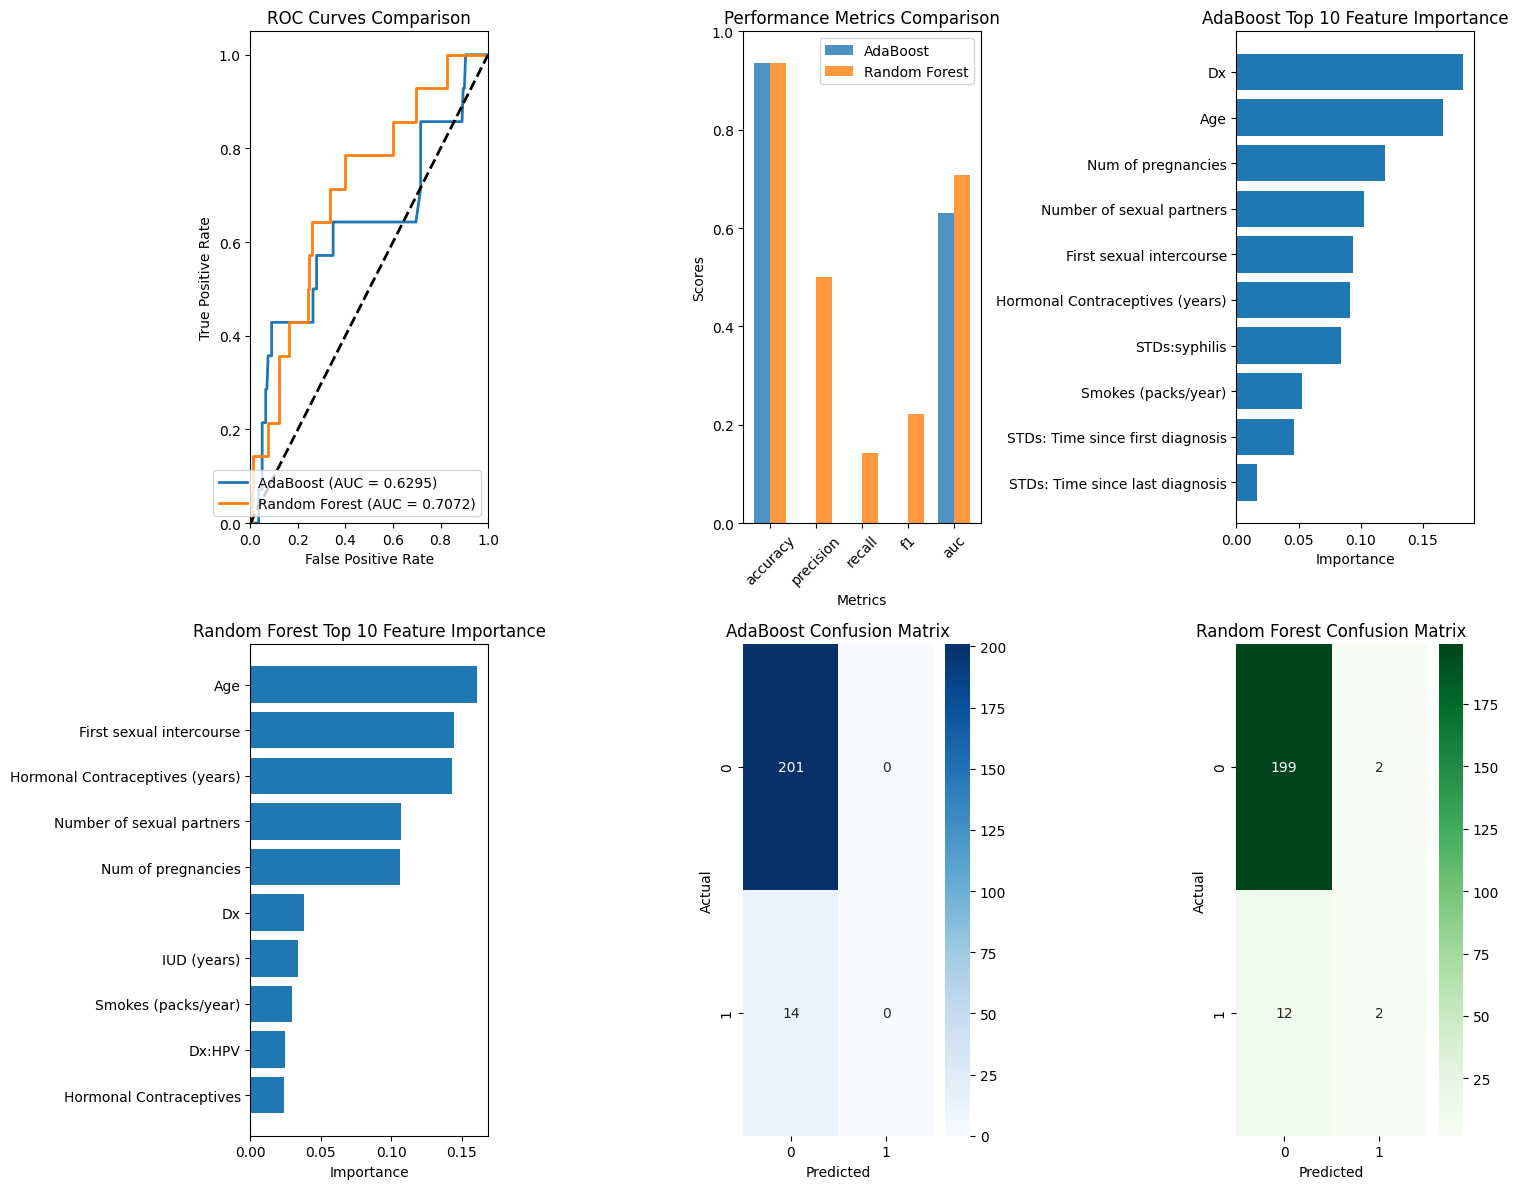

In [16]:
# 10. 可视化
plt.figure(figsize=(15, 12))

# 可视化ROC曲线对比
plt.subplot(2, 3, 1)
for name, result in results.items():
    plt.plot(result['fpr'], result['tpr'], lw=2, 
             label=f'{name} (AUC = {result["auc"]:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc="lower right")

# 将两个模型的性能指标进行对比
plt.subplot(2, 3, 2)
metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
ada_scores = [results['AdaBoost'][metric] for metric in metrics]
rf_scores = [results['Random Forest'][metric] for metric in metrics]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, ada_scores, width, label='AdaBoost', alpha=0.8)
plt.bar(x + width/2, rf_scores, width, label='Random Forest', alpha=0.8)

plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Performance Metrics Comparison')
plt.xticks(x, metrics, rotation=45)
plt.legend()
plt.ylim(0, 1)

# 可视化AdaBoost top10特征
plt.subplot(2, 3, 3)
top_ada_features = ada_feature_importance.head(10)
plt.barh(range(len(top_ada_features)), top_ada_features['importance'])
plt.yticks(range(len(top_ada_features)), top_ada_features['feature'])
plt.xlabel('Importance')
plt.title('AdaBoost Top 10 Feature Importance')
plt.gca().invert_yaxis()

# 可视化随机森林 top10特征
plt.subplot(2, 3, 4)
top_rf_features = rf_feature_importance.head(10)
plt.barh(range(len(top_rf_features)), top_rf_features['importance'])
plt.yticks(range(len(top_rf_features)), top_rf_features['feature'])
plt.xlabel('Importance')
plt.title('Random Forest Top 10 Feature Importance')
plt.gca().invert_yaxis()

# 可视化AdaBoost混淆矩阵
plt.subplot(2, 3, 5)
sns.heatmap(confusion_matrix(y_test, results['AdaBoost']['y_pred']), 
            annot=True, fmt='d', cmap='Blues')
plt.title('AdaBoost Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# 可视化随机森林混淆矩阵
plt.subplot(2, 3, 6)
sns.heatmap(confusion_matrix(y_test, results['Random Forest']['y_pred']),
            annot=True, fmt='d', cmap='Greens')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.savefig('cervical_cancer_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()